In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import PIL
from IPython.display import display 
from PIL import Image
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
#print(os.listdir("dogs-vs-cats"))
import PIL
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from zipfile import ZipFile
file_names = "/content/dogs-vs-cats.zip"
with ZipFile(file_names,'r') as zip:
  file_name = zip.extractall()
  print('done')


filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()


done


,filename,category
0,cat.4115.jpg,0
1,dog.8567.jpg,1
2,cat.11655.jpg,0
3,cat.6859.jpg,0
4,dog.5830.jpg,1


# New Section

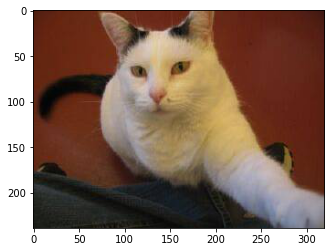

In [6]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

In [7]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 16
batch_size = 4

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=5e-5, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112,

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train", 
    x_col="filename",
    y_col="category",
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


In [13]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0)
]


history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=my_callbacks)

Epoch 1/16
   7/5625 [..............................] - ETA: 1:33:33 - loss: 0.8336 - accuracy: 0.6071

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


5625/5625 [==============================] - 354s 63ms/step - loss: 0.2289 - accuracy: 0.8988 - val_loss: 0.0157 - val_accuracy: 0.9328
Epoch 2/16
5625/5625 [==============================] - 347s 62ms/step - loss: 0.1287 - accuracy: 0.9484 - val_loss: 0.1566 - val_accuracy: 0.9688
Epoch 3/16
5625/5625 [==============================] - 344s 61ms/step - loss: 0.1092 - accuracy: 0.9568 - val_loss: 6.5549e-04 - val_accuracy: 0.9664
Epoch 4/16
5625/5625 [==============================] - 343s 61ms/step - loss: 0.0904 - accuracy: 0.9631 - val_loss: 0.1137 - val_accuracy: 0.9572
Epoch 5/16
5625/5625 [==============================] - 343s 61ms/step - loss: 0.0850 - accuracy: 0.9674 - val_loss: 4.0925e-04 - val_accuracy: 0.9668
Epoch 6/16
5625/5625 [==============================] - 342s 61ms/step - loss: 0.0774 - accuracy: 0.9685 - val_loss: 0.2138 - val_accuracy: 0.9640
Epoch 7/16
5625/5625 [==============================] - 346s 62ms/step - loss: 0.0716 - accuracy: 0.9713 - val_loss: 0.00

In [14]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.971600  ;  loss = 0.009074 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


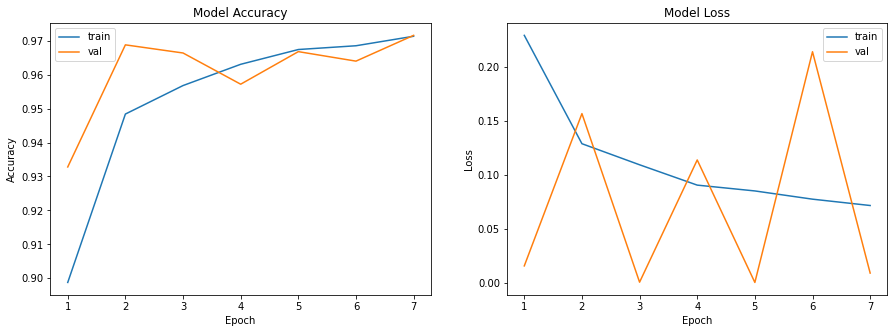

In [15]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [0]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [17]:
Y_val[0]

'0'

In [0]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [19]:
y_final.size

2500

In [26]:
file_names1 = "/content/test1.zip"
with ZipFile(file_names1,'r') as zip:
  file_name1 = zip.extractall()
  print('done1')

test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

done1


In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

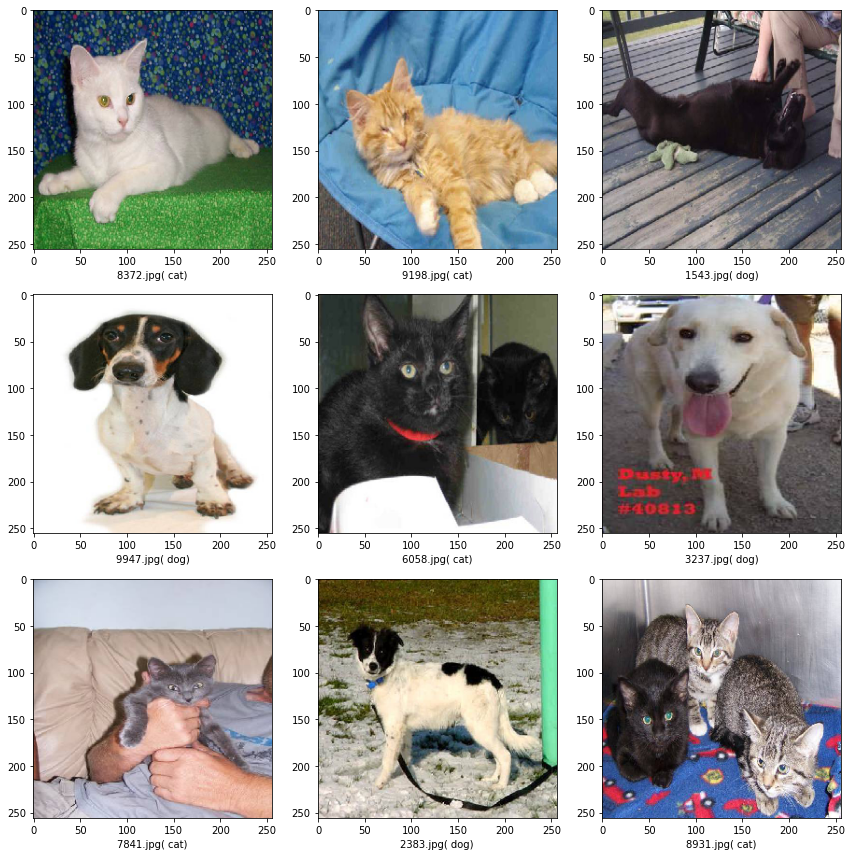

In [29]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    if category == 0:
        label_plot = ' cat'
    elif category ==1:
        label_plot = ' dog'
    plt.xlabel(filename + '(' + label_plot + ')')
plt.tight_layout()
plt.show()

In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('Submission_673_final.csv', index=False)